In [156]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pygeos
import alphashape
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from descartes import PolygonPatch
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPoint, Point

# Read csv

In [157]:
df = pd.read_csv('plots/dbscanpats13/samples/dbpats_2013_15_12.csv')
# df = pd.read_csv('plots/dbscanpubs13/samples/dbpubs_2013_15_1.csv')
df = df[df['labels']!=-1]
df

,year,lat,lng,tec,wgt,adminlat,adminlng,name,admin1,admin2,cc,radlat,radlng,minden,minpts,labels
85,2013,-34.0000,151.06700,12,1.0,-33.99941,151.06389,Como,New South Wales,Sutherland Shire,AU,-0.593412,2.636617,0.011318,8,0
86,2013,-33.9629,151.05161,12,1.0,-33.96288,151.05161,Peakhurst,New South Wales,Hurstville,AU,-0.592764,2.636348,0.016977,12,0
87,2013,-33.9500,151.11670,12,1.0,-33.95000,151.11667,Bexley,New South Wales,Rockdale,AU,-0.592539,2.637484,0.038197,27,0
88,2013,-33.9363,151.14301,12,1.0,-33.93627,151.14819,Arncliffe,New South Wales,Rockdale,AU,-0.592300,2.637943,0.046685,33,0
89,2013,-33.9258,151.10500,12,1.0,-33.93848,151.11385,Bexley North,New South Wales,Rockdale,AU,-0.592117,2.637280,0.046685,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16481,2013,61.5188,23.93580,12,1.0,61.49911,23.78712,Tampere,Pirkanmaa,Tampere,FI,1.073706,0.417759,0.060833,43,106
16482,2013,61.5194,23.93470,12,1.0,61.49911,23.78712,Tampere,Pirkanmaa,Tampere,FI,1.073716,0.417739,0.060833,43,106
16483,2013,61.5225,24.01910,12,2.0,61.46383,24.07602,Kangasala,Pirkanmaa,Tampere,FI,1.073770,0.419212,0.053759,38,106
16484,2013,61.5312,23.60260,12,1.0,61.55632,23.59606,Yloejaervi,Pirkanmaa,Tampere,FI,1.073922,0.411943,0.048100,34,106


<AxesSubplot: xlabel='lng', ylabel='lat'>

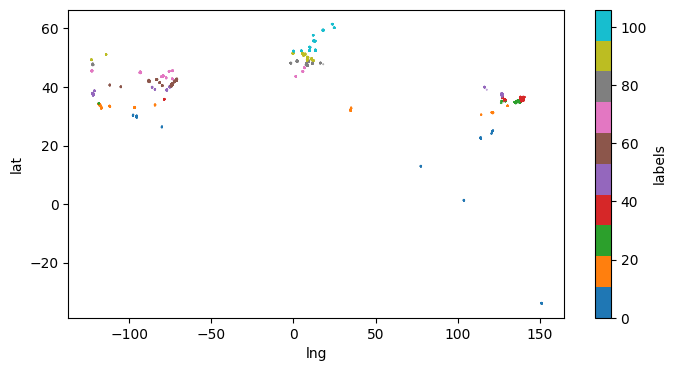

In [158]:
df.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], c='labels',cmap='tab10')

<AxesSubplot: xlabel='lng', ylabel='lat'>

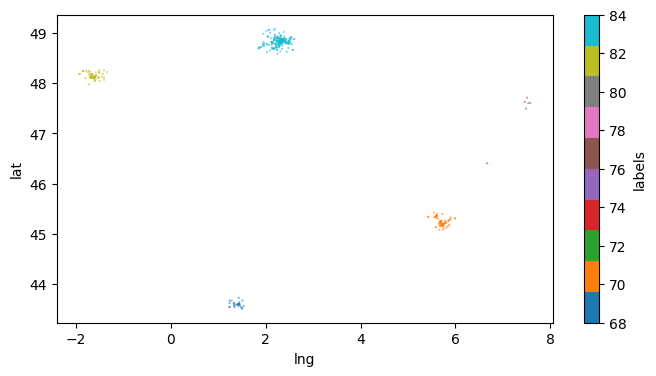

In [159]:
df[df['cc']=='FR'].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], c='labels',cmap='tab10')

# polygons

In [185]:
gdf = gpd.GeoDataFrame(df, columns=('lat','lng', 'minpts'),
                       geometry = gpd.points_from_xy(gdf['lng'], gdf['lat']),
                       crs='epsg:4326')
gdf['labels']=df['labels']
gdf.head()

,lat,lng,minpts,geometry,labels
85,-34.0000,151.06700,8,POINT (151.06700 -34.00000),0
86,-33.9629,151.05161,12,POINT (151.05161 -33.96290),0
87,-33.9500,151.11670,27,POINT (151.11670 -33.95000),0
88,-33.9363,151.14301,33,POINT (151.14301 -33.93630),0
89,-33.9258,151.10500,33,POINT (151.10500 -33.92580),0


In [186]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

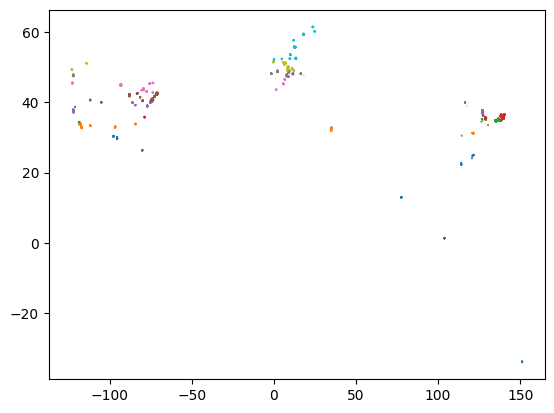

In [187]:
#Adjust eps and plot until it looks as good as possible
fig, ax = plt.subplots()
ax.scatter(x=gdf['lng'], y=gdf['lat'], c=gdf['labels'], marker='.',s=.1, cmap='tab10')

## Convex hull

In [188]:
#Create convex hulls from each cluster (alpha=0)
alpha = 0
hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
    geom = alphashape.alphashape(frame.geometry,alpha)
    if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
    else : hulls.append([clusterid, geom, False])
df0 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
df0 = gpd.GeoDataFrame(data=df0, geometry=df0['geometry'], crs=gdf.crs)
df0.head()

,cluster,geometry,polygon
0,0,"POLYGON ((151.06700 -34.00000, 150.97301 -33.8...",True
1,1,"POLYGON ((103.81117 1.26686, 103.68277 1.34622...",True
2,2,"POLYGON ((77.65450 12.84980, 77.40070 12.96350...",True
3,3,"POLYGON ((114.24371 22.26217, 114.15000 22.283...",True
4,4,"POLYGON ((114.05828 22.52683, 113.94368 22.530...",True


<AxesSubplot: >

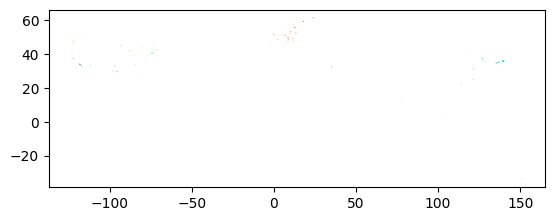

In [189]:
df0[df0.polygon].plot(cmap='rainbow')

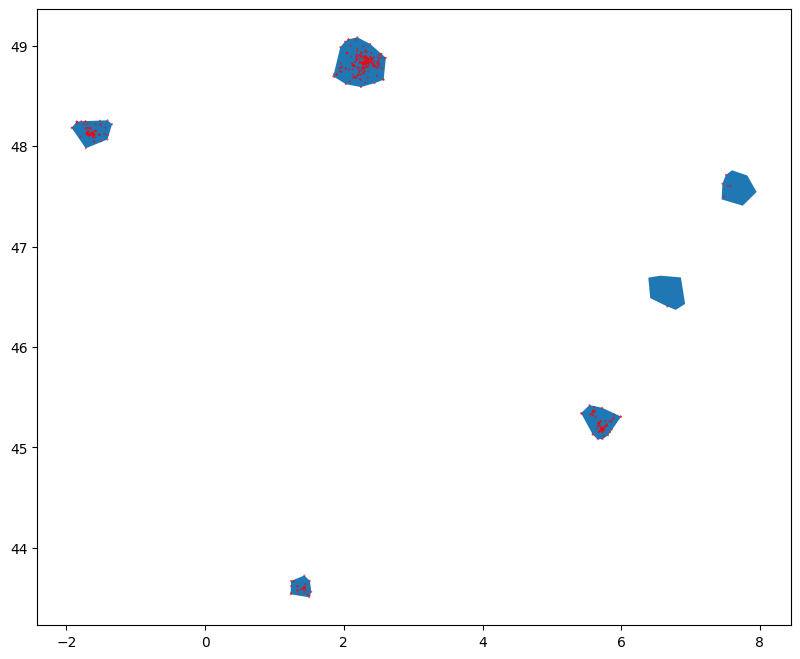

In [190]:
ctry='FR'
clus = df[df['cc']==ctry].labels.unique()
df0[df0['cluster'].isin(clus)].plot(figsize=[16,8])
X = df[df['cc']==ctry]
plt.scatter(x=X.lng, y=X.lat, s=X.wgt/10, c='red')

## Concave hull fix alpha

In [191]:
#Create concave hulls from each cluster for given alpha
alpha = 3
hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
    geom = alphashape.alphashape(frame.geometry,alpha)
    if frame.geometry.count() >= 2 : hulls.append([clusterid, geom, True])
    else : hulls.append([clusterid, geom, False])
df1 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry','polygon'])
df1 = gpd.GeoDataFrame(data=df1, geometry=df1['geometry'], crs=gdf.crs)
df1.head()

,cluster,geometry,polygon
0,0,"POLYGON ((151.27901 -33.70100, 151.28900 -33.7...",True
1,1,"POLYGON ((103.76200 1.48540, 103.84132 1.44053...",True
2,2,"POLYGON ((77.40070 12.96350, 77.58460 13.08750...",True
3,3,"POLYGON ((114.24371 22.26217, 114.17469 22.278...",True
4,4,"POLYGON ((113.81224 22.67519, 113.83141 22.759...",True


<AxesSubplot: >

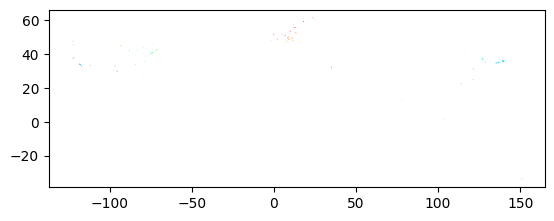

In [192]:
df1[df1.polygon].plot(cmap='rainbow')

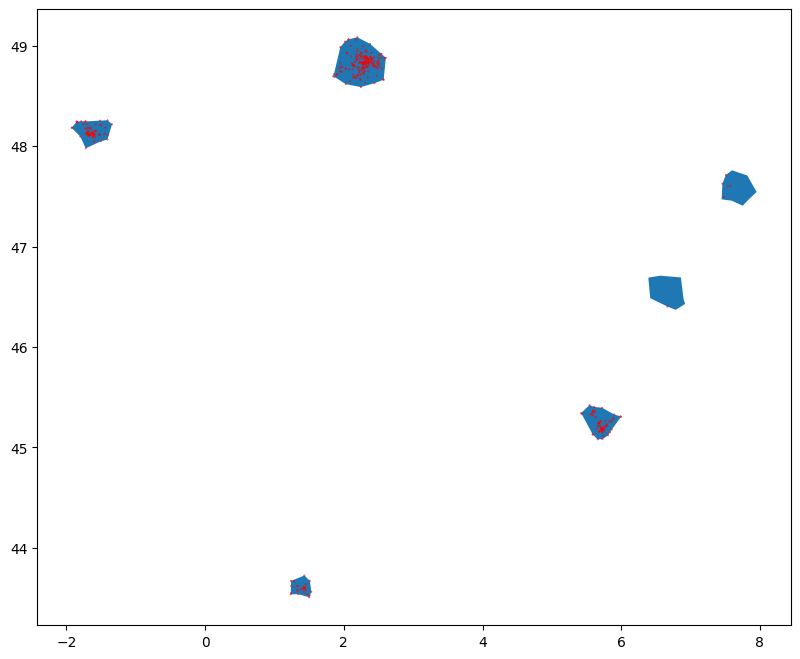

In [193]:
ctry='FR'
clus = df[df['cc']==ctry].labels.unique()
df1[df1['cluster'].isin(clus)].plot(figsize=[16,8])
X = df[df['cc']==ctry]
plt.scatter(x=X.lng, y=X.lat, s=X.wgt/10, c='red')

## Concave hull varying alpha

In [181]:
#Create concave hulls from each cluster
uberhulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
    curpts = frame.labels.count()
    alphacheck = False
    alpha = 0
    alphatop = 5
    while alphacheck == False:
        hulls = []
        geom = alphashape.alphashape(frame.geometry, alpha)
        hulls.append([clusterid, geom])
        if geom.type!='Polygon':
            alphacheck = True
            uberhulls.append([clusterid, geom, False])
        else:
            curpoly = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
            curpoly = gpd.GeoDataFrame(data=curpoly, geometry=curpoly['geometry'], crs=gdf.crs)        
            ptsinpoly = gpd.sjoin(curpoly, frame).cluster.count() #Spatial join Points to polygons
            if ptsinpoly<curpts:
                alphacheck = True
                uberhulls.append([clusterid, prevgeom, True])
                print(clusterid, alpha, curpts, ptsinpoly, (ptsinpoly/curpts*100))
            elif alpha>=alphatop:
                alphacheck = True
                uberhulls.append([clusterid, geom, True])
            else:
                alpha = alpha + .5
                prevgeom = geom    

df2 = pd.DataFrame.from_records(data=uberhulls, columns=['cluster','geometry', 'polygon'])
df2 = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=gdf.crs)

<AxesSubplot: >

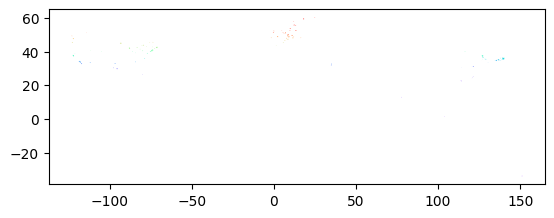

In [182]:
df2[df2.polygon].plot(cmap='rainbow')

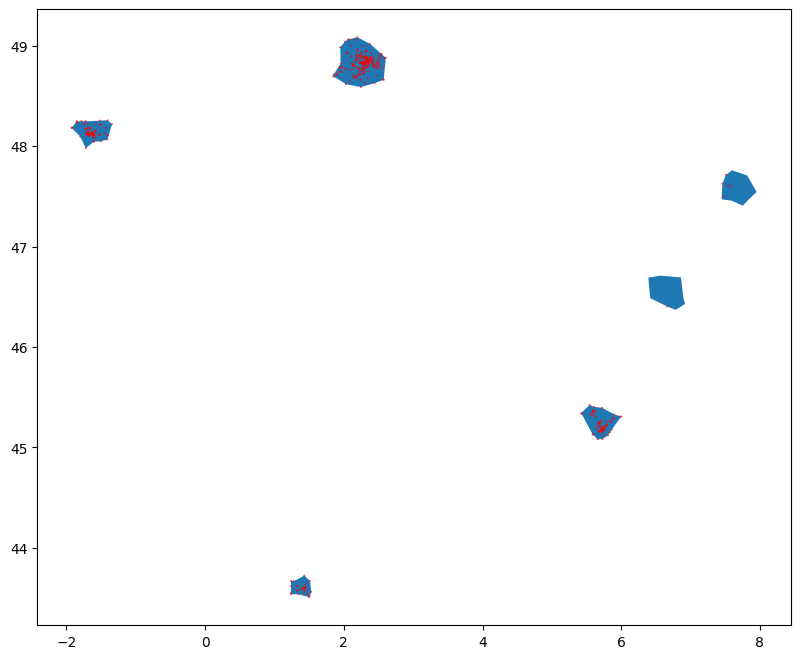

In [183]:
ctry='FR'
clus = df[df['cc']==ctry].labels.unique()
df2[df2['cluster'].isin(clus)].plot(figsize=[16,8])
X = df[df['cc']==ctry]
plt.scatter(x=X.lng, y=X.lat, s=X.wgt/10, c='red')

## Buffer circles 

In [199]:
gdf = gdf.to_crs("EPSG:32634")
print(gdf.crs)
myeps = 15

hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
    geom = frame.geometry.buffer(myeps*1000, 6).unary_union
    hulls.append([clusterid, geom])
    
df4 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
df4 = gpd.GeoDataFrame(data=df4, geometry=df4['geometry'], crs="EPSG:32634")
df4 = df4.to_crs("epsg:4326")
df4.head()

EPSG:32634


,cluster,geometry
0,0,"POLYGON ((151.41401 -33.75205, 151.40793 -33.7..."
1,1,GEOMETRYCOLLECTION EMPTY
2,2,"POLYGON ((77.54045 12.82951, 77.52172 12.83859..."
3,3,"MULTIPOLYGON (((113.92055 22.37056, 113.91668 ..."
4,4,"MULTIPOLYGON (((113.75527 22.66774, 113.75512 ..."


In [199]:
gdf = gdf.to_crs("EPSG:32634")
print(gdf.crs)
myeps = 15

hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in gdf.groupby('labels'): #For each cluster group except -1
    geom = frame.geometry.buffer(myeps*1000, 6).unary_union
    hulls.append([clusterid, geom])
    
df4 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
df4 = gpd.GeoDataFrame(data=df4, geometry=df4['geometry'], crs="EPSG:32634")
df4 = df4.to_crs("epsg:4326")
df4.head()

EPSG:32634


,cluster,geometry
0,0,"POLYGON ((151.41401 -33.75205, 151.40793 -33.7..."
1,1,GEOMETRYCOLLECTION EMPTY
2,2,"POLYGON ((77.54045 12.82951, 77.52172 12.83859..."
3,3,"MULTIPOLYGON (((113.92055 22.37056, 113.91668 ..."
4,4,"MULTIPOLYGON (((113.75527 22.66774, 113.75512 ..."


<AxesSubplot: >

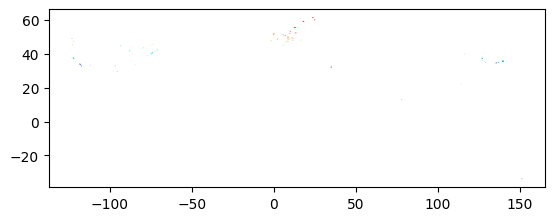

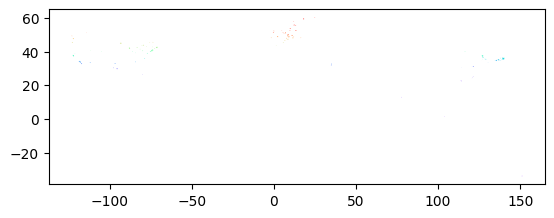

In [196]:
df3.plot(cmap='rainbow')
df2[df2.polygon].plot(cmap='rainbow')

<AxesSubplot: >

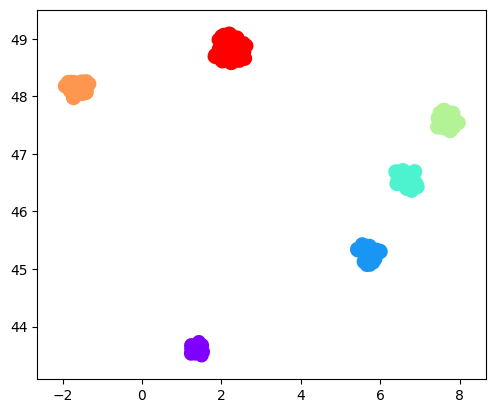

In [200]:
df4[df4['cluster'].isin(clus)].plot(cmap='rainbow')

<AxesSubplot: >

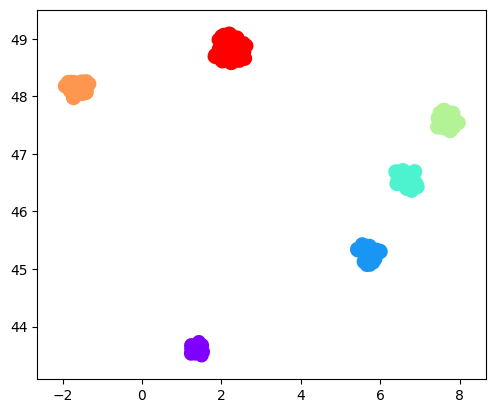

In [200]:
df4[df4['cluster'].isin(clus)].plot(cmap='rainbow')

<AxesSubplot: >

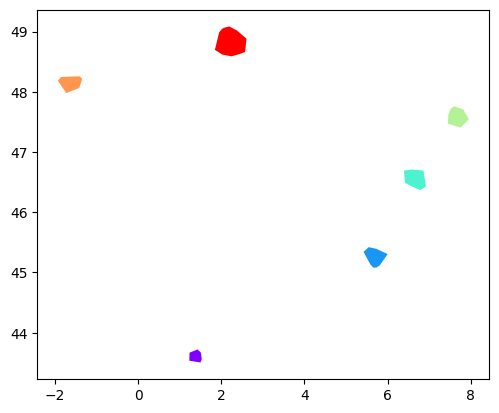

In [198]:
df0[df0['cluster'].isin(clus)].plot(cmap='rainbow')

<AxesSubplot: >

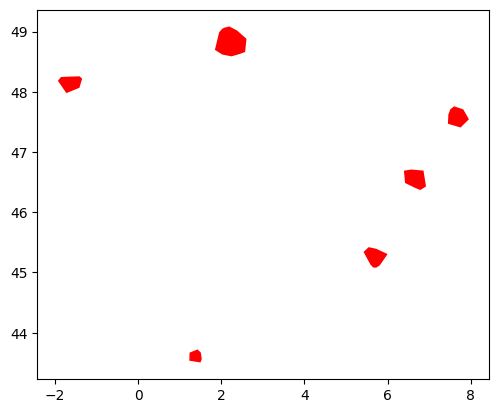

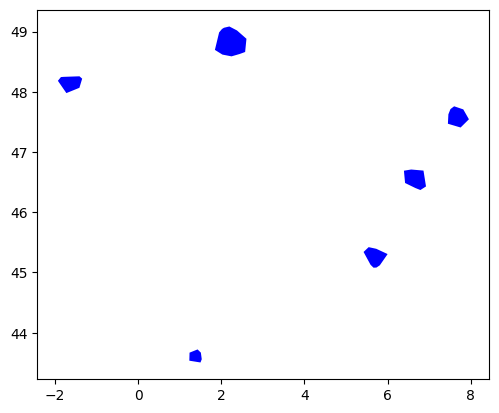

In [137]:
df3[df3['cluster'].isin(clus)].plot(color='red')
plotdf0[df0['cluster'].isin(clus)].plot(color='blue')

<AxesSubplot: >

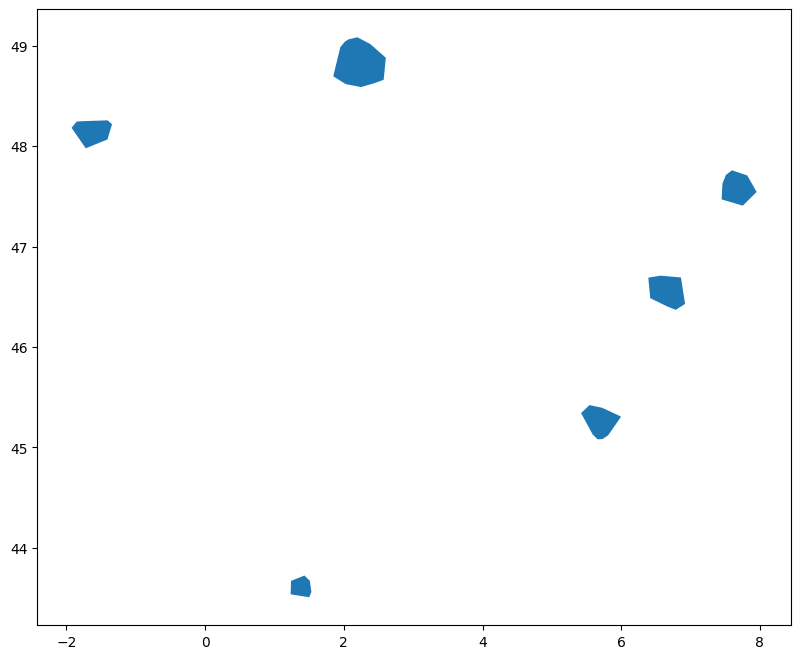

In [130]:
df3[df3['cluster'].isin(clus)].plot(figsize=[16,8])

In [112]:
df0.loc[df0.geometry.type!='Polygon']

,cluster,geometry
26,26,POINT (127.26600 34.70930)
48,48,POINT (117.72081 39.06199)
78,78,POINT (18.12670 47.73910)


In [111]:
df1.loc[df1.geometry.type!='Polygon']

,cluster,geometry
26,26,POINT (127.26600 34.70930)
48,48,POINT (117.72081 39.06199)
78,78,POINT (18.12670 47.73910)


In [110]:
df2.loc[df2.geometry.type!='Polygon']

,cluster,geometry


In [76]:
df2.head()

,cluster,geometry
0,0,POINT (-68.30000 -54.80000)
1,1,"POLYGON ((170.51010 -45.83840, 170.61670 -45.8..."
2,2,"POLYGON ((172.58330 -43.48330, 172.61670 -43.5..."
3,3,"POLYGON ((147.31940 -42.98020, 147.30920 -42.8..."
4,4,POINT (-71.31947 -42.91147)


NameError: name 'dbdf' is not defined

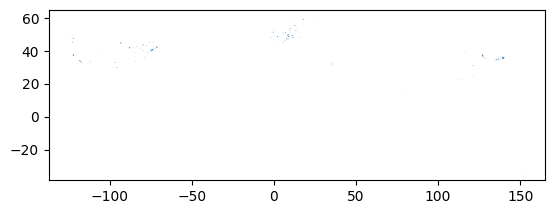

In [113]:
df2.plot()
plt.scatter(x=dbdf['lon'], y=dbdf['lat'], c=dbdf['labels'], marker='.', cmap='tab10')

# Compare shapes

In [161]:
df0.area

0    2.614865
1    2.593232
2    2.371477
dtype: float64

In [162]:
df1.area

0    2.361822
1    2.282452
2    2.176870
dtype: float64

In [163]:
df2.area

0    2.022711
1    1.900095
2    1.794160
dtype: float64

In [166]:
merged = gpd.overlay(df0, df1, how='intersection')
merged.area/df0.area

0    0.903229
1    0.880157
2    0.917938
dtype: float64

In [167]:
merged = gpd.overlay(df0, df2, how='intersection')
merged.area/df0.area

0    0.773543
1    0.732713
2    0.756558
dtype: float64

In [168]:
df2.area/df0.area

0    0.773543
1    0.732713
2    0.756558
dtype: float64